## Read the data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import re
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.pyplot as plt

In [2]:
covid = pd.read_excel('data/covid_enriched.xlsx')
covid['data_set'] = 'covid'
random = pd.read_excel('data/random_enriched.xlsx')
random['data_set'] = 'random'
fiveG = pd.read_excel('data/5G_enriched.xlsx')
fiveG['data_set'] = '5G'
df = pd.concat([covid, random, fiveG])
df['id_str'] = df['id_str'].astype(str)
print("initial df size: " + str(len(df)))
df = df[df['created_at'].isnull() == False]
print("size after removing null values: " + str(len(df)))
df = df[df['status_lang'] == 'en']
print("size after removing non-english accounts: " + str(len(df)))
df = df.reset_index(drop=True)

initial df size: 28685
size after removing null values: 28684
size after removing non-english accounts: 18264


## Format data

In [3]:
df['created_at'] = df['created_at'].apply(lambda x: datetime.datetime.strptime(str(x), '%a %b %d %H:%M:%S +0000 %Y'))
df['status_created_at'] = df['status_created_at'].apply(lambda x: datetime.datetime.strptime(str(x), '%a %b %d %H:%M:%S +0000 %Y'))

## Generate additional features

In [4]:
# calculate account age
df['user_age'] = df.apply(lambda x: x['status_created_at'] - x['created_at'], axis=1)
df['user_age'] = df['user_age'].apply(lambda x: x.days + 1)

# calculate growth rates
df['tweet_freq'] = df.apply(lambda x: x['statuses_count']/x['user_age'], axis=1)
df['followers_growth_rate'] = df.apply(lambda x: x['followers_count']/x['user_age'], axis=1)
df['friends_growth_rate'] = df.apply(lambda x: x['friends_count']/x['user_age'], axis=1)
df['favourites_growth_rate'] = df.apply(lambda x: x['favourites_count']/x['user_age'], axis=1)
df['listed_growth_rate'] = df.apply(lambda x: x['listed_count']/x['user_age'], axis=1)

# calculate ratios
def divide(a, b):
    if b == 0:
        return np.nan
    else: 
        return a/b   
df['follower_friend_ratio'] = df.apply(lambda x: divide(x['followers_count'], x['friends_count']), axis=1)
df['follower_favorites_ratio'] = df.apply(lambda x: divide(x['followers_count'], x['favourites_count']), axis=1)
df['tweet_follower_ratio'] = df.apply(lambda x: divide(x['statuses_count'], x['followers_count']), axis=1)
df = df.replace([np.inf, -np.inf], np.nan)
df["follower_friend_ratio"].fillna("0", inplace = True)
df["follower_favorites_ratio"].fillna("0", inplace = True)
df["tweet_follower_ratio"].fillna("0", inplace = True)
df['follower_friend_ratio'] = df['follower_friend_ratio'].astype(float)
df['follower_friend_ratio'] = df['follower_friend_ratio'].round(10)
df['follower_favorites_ratio'] = df['follower_favorites_ratio'].astype(float)
df['follower_favorites_ratio'] = df['follower_favorites_ratio'].round(10)
df['follower_friend_ratio'] = df['follower_friend_ratio'].astype(float)
df['tweet_follower_ratio'] = df['follower_friend_ratio'].round(10)

# calculate name length features
df['name_length'] = df['name'].apply(lambda x: len(str(x)))
df['description_length'] = df['description'].apply(lambda x: len(str(x)))
df['screen_name_length'] = df['screen_name'].apply(lambda x: len(str(x)))
df["screen_name_length"].fillna("0", inplace = True)
df['num_digits_in_screen_name'] = df['screen_name'].apply(lambda x: len(re.findall("[0-9]", x)))
df['num_digits_in_name'] = df['name'].apply(lambda x: len(re.findall("[0-9]", str(x))))

# calculate number of digits at the end of a name
def count_digits_at_end_name(screen_name):
    screen_name_length = len(screen_name)
    midpoint = int(screen_name_length/2)
    end_of_name = screen_name[midpoint:screen_name_length]    
    count = len(re.findall("[0-9]", end_of_name))
    return count
df['num_digits_end_screen_name'] = df['screen_name'].apply(lambda x: count_digits_at_end_name(x))
                
                
# calculate screen name entropy
def character_freq_distribution(screen_names):
    
    def split(word): 
        return [char for char in word]  

    #split characters and combine into one column
    characters = []
    for name in screen_names:
        characters = characters + split(name)
    characters = pd.DataFrame({'value': characters})

    #calculate character counts and frequency
    char_freq = characters['value'].value_counts().reset_index()
    char_freq.columns = ['character', 'count']
    char_freq['freq'] = char_freq['count'].apply(lambda x: x/len(characters))
    return char_freq

def calc_screen_name_likelihood(screen_name, char_freq):
    probabilities = char_freq['freq'][char_freq['character'].isin([char for char in screen_name])]
    entropy = sum([-prob*math.log2(prob) for prob in probabilities])
    return entropy 

screen_names = df['screen_name'].tolist()
char_freq = character_freq_distribution(screen_names)
df['screen_name_likelihood'] = df['screen_name'].apply(lambda x: calc_screen_name_likelihood(x, char_freq))

## Filter to features and response

In [7]:
user_metadata_cols = ['statuses_count', 'followers_count', 'friends_count',
                      'favourites_count', 'listed_count', 'has_default_profile',
                      'verified']
derived_features = ['tweet_freq', 'followers_growth_rate', 'friends_growth_rate',
                    'favourites_growth_rate', 'listed_growth_rate', 
                    'follower_friend_ratio', 'follower_favorites_ratio', 'tweet_follower_ratio', 
                    'screen_name_length', 'num_digits_in_screen_name',
                    'name_length', 'num_digits_in_name', 'num_digits_end_screen_name',
                    'description_length', 'screen_name_likelihood']
response = ['fake_follower_raw_en', 'spammer_raw_en', 'cap_en']
benchmark = ['bot_lite']
df = df[user_metadata_cols + derived_features + response + benchmark]
df.to_excel("data/processed_data.xlsx")

## Identify best performing combination of threshold values

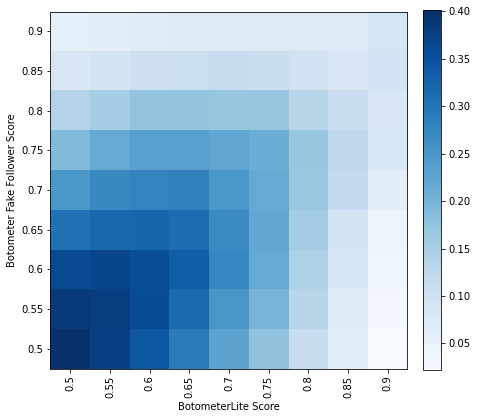

In [19]:
def tune_threshold(k):
    bot_lite_threshold = k
    benchmark = pd.DataFrame({'bot_lite_prediction': df['bot_lite'] >= bot_lite_threshold,
                              'botometer_label': df['bot']})
    true_pos = sum((benchmark['bot_lite_prediction'] == True) & (benchmark['botometer_label'] == True))
    false_pos = sum((benchmark['bot_lite_prediction'] == True) & (benchmark['botometer_label'] == False))
    true_neg = sum((benchmark['bot_lite_prediction'] == False) & (benchmark['botometer_label'] == False))
    false_neg = sum((benchmark['bot_lite_prediction'] == False) & (benchmark['botometer_label'] == True))
    precision = true_pos/(true_pos + false_pos)
    bot_count = true_pos + false_neg
    recall = true_pos/(true_pos + false_neg)
    f1 = 0
    try:
        f1 = 2*(precision*recall)/(precision+recall)
    except:
        pass
    return f1, precision, recall, bot_count

threshold_increments = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

# Perform a grid search for the top F1 score
f1_scores = []
for j in threshold_increments[::-1]:
    df['bot'] = df['fake_follower_raw_en'] >= j
    for k in threshold_increments[::-1]:        
        f1 = pd.DataFrame({'j': [j],
                           'k': [k],
                           'precision': tune_threshold(k)[1],
                           'recall': tune_threshold(k)[2],
                           'f1': tune_threshold(k)[0],
                           'bot_count': tune_threshold(k)[3]})        
        #print(f1)
        f1_scores.append(f1)
f1_scores = pd.concat(f1_scores)

marks = np.array([f1_scores['f1'][f1_scores['j'] == 0.9].tolist()[::-1],
                  f1_scores['f1'][f1_scores['j'] == 0.85].tolist()[::-1],
                  f1_scores['f1'][f1_scores['j'] == 0.8].tolist()[::-1],
                  f1_scores['f1'][f1_scores['j'] == 0.75].tolist()[::-1],
                  f1_scores['f1'][f1_scores['j'] == 0.7].tolist()[::-1],
                  f1_scores['f1'][f1_scores['j'] == 0.65].tolist()[::-1],
                  f1_scores['f1'][f1_scores['j'] == 0.6].tolist()[::-1],
                  f1_scores['f1'][f1_scores['j'] == 0.55].tolist()[::-1],
                  f1_scores['f1'][f1_scores['j'] == 0.5].tolist()[::-1]])
 

plt.xticks(ticks=np.arange(len(threshold_increments)),labels=threshold_increments,rotation=90)
plt.yticks(ticks=np.arange(len(threshold_increments[::-1])),labels=threshold_increments[::-1])
# save this plot inside a variable called hm
hm=plt.imshow(marks, cmap='Blues',interpolation="nearest")
# pass this heatmap object into plt.colorbar method.
plt.xlabel('BotometerLite Score')
plt.ylabel('Botometer Fake Follower Score')
plt.colorbar(hm, fraction=0.046, pad=0.04)
plt.rcParams["figure.figsize"]=7,7

In [20]:
def plot_thresholds(bot_type, threshold):
    df['bot'] = df[bot_type] >= threshold
    f1_scores = []
    for k in range(0,100):
        f1 = pd.DataFrame({'j': threshold,
                           'k': [k/100],
                           'f1': tune_threshold(k/100)[0],
                           'precision': tune_threshold(k/100)[1],
                           'recall': tune_threshold(k/100)[2],
                           'bot_count': tune_threshold(k/100)[3]})    
        f1_scores.append(f1)
    f1_scores = pd.concat(f1_scores)
    print(f1_scores[f1_scores['f1'] == max(f1_scores['f1'])])
    plt.scatter(f1_scores.k, f1_scores.f1)
    plt.xlabel('BotometerLite Threshold, k')
    plt.ylabel('F1 Score')

     j     k        f1  precision    recall  bot_count
0  0.5  0.45  0.420066    0.38419  0.463333       1500
     j     k        f1  precision    recall  bot_count
0  0.6  0.54  0.370023   0.321792  0.435262        726
     j     k        f1  precision    recall  bot_count
0  0.7  0.58  0.283906   0.204694  0.463127        339
     j     k        f1  precision    recall  bot_count
0  0.8  0.69  0.175313   0.120393  0.322368        152


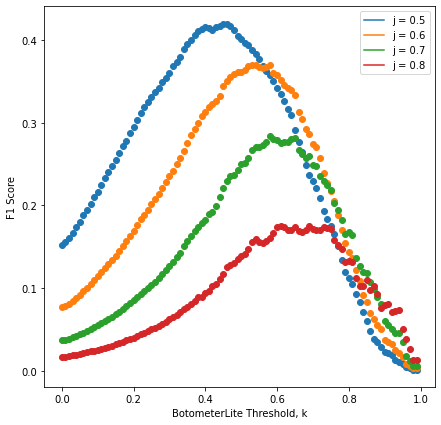

In [21]:
plot_thresholds('fake_follower_raw_en', 0.5)
plot_thresholds('fake_follower_raw_en', 0.6)
plot_thresholds('fake_follower_raw_en', 0.7)
plot_thresholds('fake_follower_raw_en', 0.8)
plt.plot(0.9, 0.3, label="j = 0.5")
plt.plot(0.9, 0.3, label="j = 0.6")
plt.plot(0.9, 0.3, label="j = 0.7")
plt.plot(0.9, 0.3, label="j = 0.8")
plt.legend(loc="upper right")
plt.rcParams["figure.figsize"]=7,7

     j     k        f1  precision    recall  bot_count
0  0.7  0.14  0.670324   0.600953  0.757801       7820
     j     k        f1  precision    recall  bot_count
0  0.8  0.34  0.377038   0.302948  0.499101       2224
     j     k        f1  precision    recall  bot_count
0  0.9  0.67  0.305483       0.25  0.392617        298


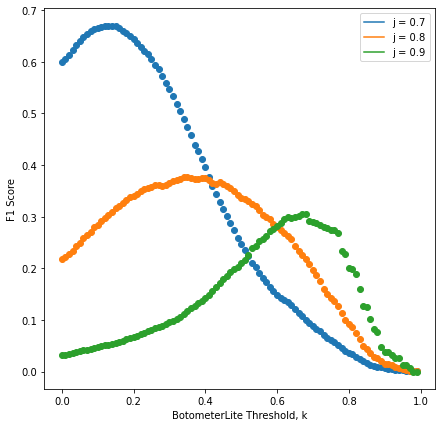

In [22]:
plot_thresholds('cap_en', 0.7)
plot_thresholds('cap_en', 0.8)
plot_thresholds('cap_en', 0.9)
plt.plot(0.9, 0.3, label="j = 0.7")
plt.plot(0.9, 0.3, label="j = 0.8")
plt.plot(0.9, 0.3, label="j = 0.9")
plt.legend(loc="upper right")
plt.rcParams["figure.figsize"]=7,7